## Task # 2
In this task we train a neural network to map images to a 3D point cloud,
where each pixel is mapped to its corresponding 3D point in space. As training
dataset use a split of any 3D dataset (pick one) such as BlendedMVS (https://
github.com/YoYo000/BlendedMVS), or Matterport3D (https://niessner.
github.io/Matterport/#download), or Megadepth (https://www.
cs.cornell.edu/projects/megadepth/), just to name a few examples,
and use a sufficient number of samples of the remaining part from the split as test
set. Choose a meaningful split. The design of the network architecture is your
choice. See examples in the literature that could be suitable and train your model
from scratch. The data should allow you to build a dataset of image and corresponding 3D point cloud pairs. More precisely, the input image is defined as
x ∈ R
M×N×3
and the output 3D point cloud is defined as X ∈ R
M×N×3
, where
M is the number of image rows and N is the number of image columns. In the
image 3 refers to the number of color channels (RGB), while in the 3D point cloud
X the dimension 3 refers to the number of coordinates of each 3D point. Evaluate
the model on your test set. Show quantitative evaluations (the choice of the metric
is up to you and I recommend looking up in the literature to see what is typically used) and also qualitative evaluations by showing useful examples and by
illustrating important observations on how (well or poorly) the model performs.
Describe each step of the implementation directly with the code (as in Task 1) and
also provide comments on your evaluation.


# **Solution:**
For this task, we will proceed with the BlendedMVS dataset. However, due to computational resource limitations, we will not be able to work with the entire dataset and will instead use approximately 8,000 images due to storage constraints.

# Proposal:
We will follow a similar NN architecture to that presented in the paper [Vision Transformers for Dense Prediction](https://arxiv.org/abs/2103.13413).
The idea is that 3D point reconstruction to a Pinhole Camera Model, where the pixel coordinates $\textbf{x}$ of the image is related to the world coordinate system $\textbf{X}_{\text{world}}$ as follows

$$Z(u,v)\textbf{x} = K \left[R | T\right]\textbf{X}_{\text{world}}$$

where $Z(u,v)$ is the depth estimation, that relates to the disparity maps $D(u,v)$ of the dataset as
$$Z(u,v) = \frac{f \cdot B}{D(u,v)}$$ with $f$ the focal length, and $B=1$ for relative depth in our case, $K$ is the intrinsics matrix

$$K =
\begin{bmatrix}
f & 0 & c_x \\
0 & f & c_y \\
0 & 0 & 1
\end{bmatrix}$$,
with $c_x$, $c_y$ the coordinate of the principal point in the image, $[R | T]$ the extrinsic matrix given by a rotation $R$ and a translation
$$ [R | t] = \begin{bmatrix} R_{3\times 3} & T_{3\times 3} \\ 0_{3 \times 3} & 1 \end{bmatrix},\quad R =
\begin{bmatrix}
r_{11} & r_{12} & r_{13} \\
r_{21} & r_{22} & r_{23} \\
r_{31} & r_{32} & r_{33}
\end{bmatrix}, \quad T =
\begin{bmatrix}
t_x \\
t_y \\
t_z
\end{bmatrix}$$,
and the coordinates are
$$\textbf{x} = \begin{bmatrix} u \\ v\\ 1\end{bmatrix}, \quad \textbf{X}_{\text{world}} = \begin{bmatrix} X\\ Y \\ Z \\ 1\end{bmatrix}$$ with $(u,v)$ the pixel coordinates "$(0,0)$" the top most left pixle and so on. On the camera system
$$\begin{bmatrix}X_{\text{cam}} \\ Y_{\text{cam}} \\ Z_{\text{cam}} \end{bmatrix} = [R|T] \textbf{X}_{\text{world}}$$, the depth is equal to the $Z$-coordinate $Z_{\text{cam}} = Z$. The following diagram gives a good illustration of these (from [stackoverflow](https://stackoverflow.com/questions/38494485/camera-coordinate-to-pixel-coordinate-opencv))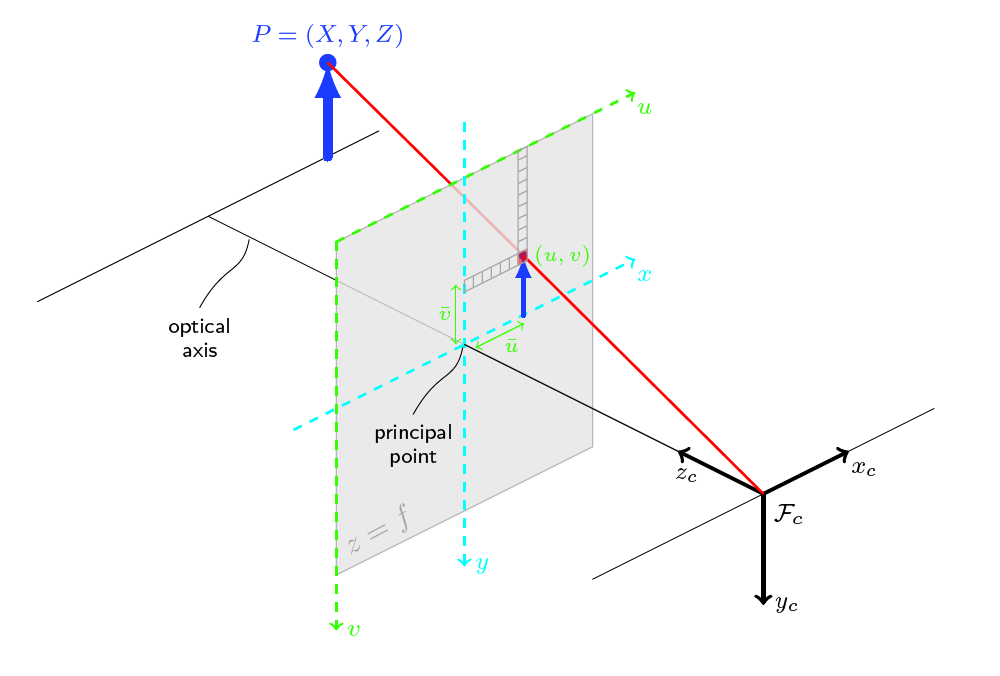
Hence, we can reconstruct the 3D world coordinates by inverting the first equation as

$$\textbf{X}_{\text{world}} =  \left[R | T\right]^{-1} K^{-1}Z(u,v)\textbf{x} $$.

Therefore, our problem can be address as a monocular depth estimation problem to determine $Z$.

**References:**
1. Hartley, R., & Zisserman, A. (2004). Multiple View Geometry in Computer Vision (2nd ed.). Cambridge University Press.
2. Camera Calibration and 3D Reconstruction — OpenCV 2.4.13.0 documentation. (n.d.). Opencv.org. Retrieved December 13, 2024, from https://docs.opencv.org/2.4.13/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html


For the Monocular Depth Estimation, we will follow the NN architechture from the Vision Transformers for Dense Prediction paper:

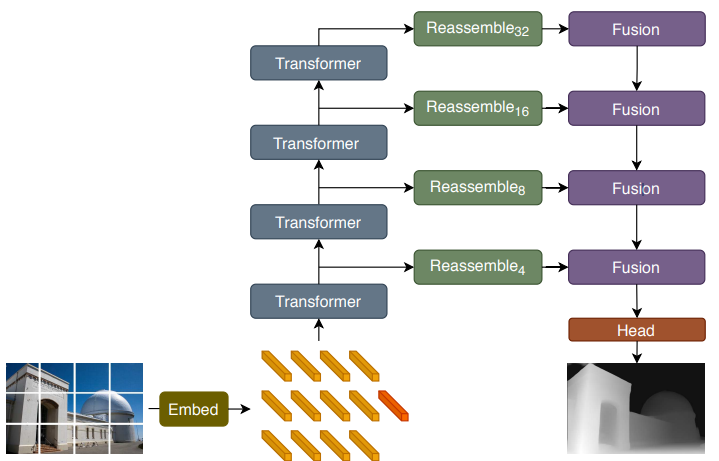

We will go over the details on the nexts parts of the code.

In [1]:
#import of necessary modules
import torch
import gc
from torch.utils.data import DataLoader, Dataset, random_split
import imageio
from torchvision.io import decode_image
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import os
from IPython.display import clear_output,display
drive.mount('/content/drive')
%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# some handlinfg and cache cleaning for gpu operations
os.environ["PYTORCH_CUDA_ALLOC_CONF"]="expandable_segments:True"

In [3]:
#some functions to handle cuda memory
def clear_cache():
  gc.collect()
  torch.cuda.empty_cache()
  torch.cuda.empty_cache()  # Clears the cache
  torch.cuda.reset_peak_memory_stats()  # Resets peak memory tracking
  torch.cuda.reset_accumulated_memory_stats()
  with torch.no_grad():
      torch.cuda.empty_cache()
def check_gpu_memory():
  device = torch.device("cuda")
  free_mem, total_mem = torch.cuda.mem_get_info(device)
  print(f"Free memory: {free_mem / 1e9:.2f} GB")
  print(f"Total memory: {total_mem / 1e9:.2f} GB")

In [4]:
data_path = '/content/drive/My Drive/depth_data'

In [5]:
#function to extract the intrinsics and extrinsics of the cameras
def extract_cam_details(cam_path:str):
  """
  Extracts camera intrinsic and extrinsic matrices from a camera details file.

  Args:
  - cam_path (str): Path to the camera details file. The file should contain 'extrinsic' and 'intrinsic' sections with matrix data.

  Returns:
  - tuple: A tuple containing the intrinsic and extrinsic matrices as NumPy arrays.
  """
  extrinsic = []
  intrinsic = []
  current_matrix = None
  with open(cam_path, 'r') as file:
    lines = file.readlines()
  for line in lines:
    line = line.strip()
    if line == "extrinsic":
        current_matrix = extrinsic
    elif line == "intrinsic":
        current_matrix = intrinsic
    elif line:
        current_matrix.append([float(x) for x in line.split()])

  extrinsic_matrix = np.array(extrinsic)
  try:
    intrinsic_matrix = np.array(intrinsic)
  except ValueError:
    intrinsic_matrix = np.array([row for row in intrinsic if len(row)==3])
  return intrinsic_matrix, extrinsic_matrix

Dataset custom class that implement lazy loading of the images, camera details and depths

In [6]:
class ImageDataset(Dataset):
    """
    A PyTorch Dataset for loading images, depth maps, and camera details from a specified directory.

    Args:
    - data_path (str): Path to the root directory containing images, camera details, and depth maps.
    - device (optional): Device to which the data should be moved (default is None, and the data is returned on the default device).

    Properties:
    - data: A list of valid data paths (image, camera, depth map tuples) after filtering invalid ones.

    Methods:
    - __len__(): Returns the number of valid data entries in the dataset.
    - __getitem__(idx): Returns the image, depth map, and camera details for the given index.
    - _filter_valid_data(): Filters and returns only valid image-camera-depth map pairs.
    - _load_data_filenames(): Loads and returns sorted lists of image, camera detail, and depth map filenames from the data directory.
    - extract_cam_details(cam_path): Extracts camera extrinsic and intrinsic matrices from the camera detail file.
    """
    def __init__(self, data_path: str, device=None):

        self._data_path = data_path
        self._data = self._filter_valid_data()

    @property
    def data(self):
        return self._data

    def __len__(self):
        return len(self._data)

    def __getitem__(self, idx):
        img_path, cam_path, depth_path = self._data[idx]

        img_tensor = decode_image(img_path)

        cam_detail = self.extract_cam_details(cam_path)

        depth = torch.tensor(imageio.v2.imread(depth_path), dtype=torch.float32).unsqueeze(0)

        return img_tensor, depth, cam_detail

    def _filter_valid_data(self):
        images, cam_details, depths = self._load_data_filenames()
        valid_data = []

        for img_path in images:
            img_split = img_path.split("/")
            img_name = img_split[-1].replace("_masked", "").split(".")[0]
            img_subfolder = img_split[-3]
            cam_path = next((s for s in cam_details if (img_name in s and img_subfolder in s)), None)
            depth_path = next((s for s in depths if (img_name in s and img_subfolder in s)), None)

            if cam_path and depth_path:
                valid_data.append((img_path, cam_path, depth_path))

        return valid_data

    def _load_data_filenames(self):
        images, cam_details, depths = [], [], []
        for dirpath, _, filenames in os.walk(self._data_path):
            for file in filenames:
                if file.endswith('.jpg'):
                    images.append(os.path.join(dirpath, file))
                elif file.endswith('.txt'):
                    cam_details.append(os.path.join(dirpath, file))
                elif file.endswith('.pfm'):
                    depths.append(os.path.join(dirpath, file))
        return sorted(images), sorted(cam_details), sorted(depths)

    def extract_cam_details(self, cam_path):
        with open(cam_path, 'r') as f:
            lines = f.readlines()
        extrinsic, intrinsic = [], []
        current = None
        for line in lines:
            line = line.strip()
            if line == "extrinsic":
                current = extrinsic
            elif line == "intrinsic":
                current = intrinsic
            elif line:
                current.append([float(x) for x in line.split()])

        extrinsic_matrix = np.array(extrinsic)
        try:
          intrinsic_matrix = np.array(intrinsic)
        except ValueError:
          intrinsic_matrix = np.array([row for row in intrinsic if len(row)==3])
        return {
            "extrinsic": extrinsic_matrix,
            "intrinsic": intrinsic_matrix,
        }

In [7]:
dataset = ImageDataset(data_path)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

"We begin by patchifying the image tensor into a vector embeddings of patches of shape $P\times P$, where $P$ is the patch size. These patches get flattened and projected into a vector representation of dimension $D$ using a linear transformation. Thus, going from an image of dimensions $C \times H \times W$ to a tensor of shape $\frac{H}{P}\cdot \frac{W}{P} \times D$. We then add a positional embedding to each patch on this representation and finally concat a readout token to the entire representation, returning a representation vector of $N_p +1 \times D$ dimensions with $N_p = \frac{HW}{p^2}$. In the base version of the model, they set $D=768$ in the paper.

In [8]:
class encoder(torch.nn.Module):
  """
  A module that processes an image through patching, flattening, and embedding
  to prepare it for subsequent transformer layers.

  Args:
  - patch_size (int): The size of each patch the image is divided into.
  - dimensions (int): The embedding dimension for the patches and the CLS token.
  - img_dimensions (tuple): The dimensions of the input image (batch size, channels, height, width).

  Methods:
  - patch_img(img, patch_size): Divides the input image into non-overlapping patches.
  - flatten_linear(patches, dimensions): Flattens the patches and projects them to the desired embedding dimension.
  - forward(img): Prepares the image by generating patches, embedding them, and adding positional encoding.

  Properties:
  - _cls_token: The class token used in transformer models.
  - _patch_size: The size of each image patch.
  - _dimensions: The embedding dimensions for the patches and class token.
  - _img_dim: The dimensions of the input image.
  """
  def __init__(self, patch_size:int, dimensions:int, img_dimensions:tuple):
    super().__init__()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.to(device)
    self._img_dim = img_dimensions

    self._patch_size = patch_size
    self._dimensions = dimensions
    self._cls_token = torch.nn.Parameter(torch.randn(1, dimensions)).to(device)
    self.linear = torch.nn.Linear(img_dimensions[-3]*patch_size*patch_size,dimensions).to(device)
    self.positional_embeddings = torch.nn.Parameter(torch.randn(int((img_dimensions[-1]/patch_size)*(img_dimensions[-2]/patch_size)), self._dimensions)).to(device)

  @staticmethod
  def patch_img(img:torch.Tensor, patch_size:int):

    batches, channels, height, width = img.shape

    assert height % patch_size == 0 and width % patch_size == 0, "Height and width must be divisible by patch size"

    patches = img.unfold(dimension = 2,size= patch_size,step = patch_size).unfold(dimension=3, size=patch_size, step=patch_size).permute(0, 2, 3, 1, 4, 5).reshape(batches,-1, channels, patch_size, patch_size)
    return patches

  def flatten_linear(self,patches:torch.Tensor,dimensions:int):
    patches_flattened = patches.float().flatten(start_dim=-3)

    return self.linear(patches_flattened)

  def forward(self,img:torch.Tensor):
    single_image = False
    if img.dim() == 3:
      single_image = True
      img = img.unsqueeze(0)

    batch_size = img.size(0)

    expanded_positional_embeddings = self.positional_embeddings.unsqueeze(0).expand(batch_size, -1, -1)
    cls_token = self._cls_token.expand(batch_size, -1, -1)

    patches = self.patch_img(img,self._patch_size)
    flattened_patches = self.flatten_linear(patches,self._dimensions)

    embedded_tokens = flattened_patches + expanded_positional_embeddings
    if single_image:
      return torch.cat([cls_token,embedded_tokens],dim=-2).squeeze(0)
    else:
      return torch.cat([cls_token,embedded_tokens],dim=-2)



Before diving into the transformer acrhitecture, we first construct the reassemble layer as shown in the image:

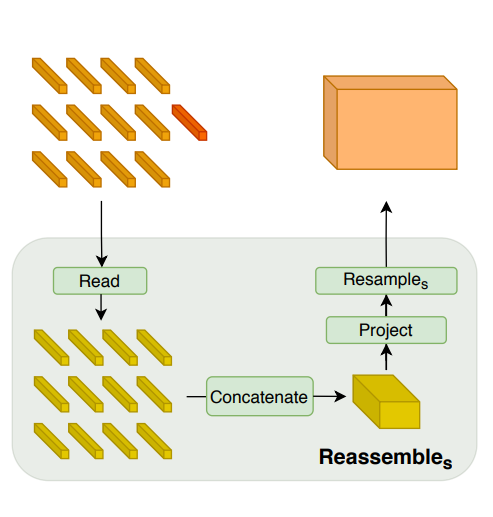

The mathematical model for this layer consists of a read function, composed of a concatenation function, and finally a resample function:
$$\text{Reassemble}_s^{\hat{D}}(t) = \left(\text{Resample}_s\,  \circ \, \text{Concatenate} \, \circ \, \text{Read}\right)(t)$$

The read function is the mapping
$$\text{Read}: \mathbb{R}^{N_p +1 \times D} \to \mathbb{R}^{N_p \times D}$$,
and consists of a concatenation of each patch with the readout token followed by a linear mapping and a GELU non-linearity, we denote this as $\text{mlp}$:
$$Read(t) = \left\{\text{mlp}(\text{cat}(t_i,t_0))\right\}_{i=1}^{N_p}$$ with $t_0$ the readout token.

The concatenate function is simply a spatial concatenation
$$\text{Concatenate}: \mathbb{R}^{N_p \times D}\to \mathbb{R}^{\frac{H}{P}\times \frac{W}{P}\times D}$$.

The resample function is the mapping
$$\text{Resample}_s: \mathbb{R}^{\frac{H}{P}\times \frac{W}{P}\times D} \to \mathbb{R}^{\frac{H}{s}\times \frac{W}{s}\times \hat{D}}.$$
This is done by a $1\times 1$ conv layer as a projection to go from $D$ to $\hat{D}$, and then a $3\times 3$ conv layer if $s\geq P$ or a $3\times 3$ transpose conv if $s < P$. In the paper, $\hat{D}=256$ is set.

In order to properly define the conv or transpose conv layers, we need to properly handle the stride and the padding to ensure thet the final dimensions are $\frac{H}{s}\times \frac{W}{s}$.

For the conv layer, the output dimensions follow the rule
$$D_{\text{out}} = \left\lfloor \frac{D_{\text{in}} - K + 2P}{S} \right\rfloor + 1, \quad D \in \{H,W\},$$ hence, substituting $D_{\text{out}} = \frac{H}{s}$ and $D_{\text{in}} = \frac{H}{P}$ we can see that a natrual selectuion for the stride is $S = \frac{s}{P}$, from where we arrive to
$$\frac{H}{s} = \frac{H}{s} + \frac{P}{s}\left( -K + 2P\right) + 1,$$ and then, this equation holds if and only if
$$ \frac{P}{s}\left( -K + 2P\right) + 1 = 0 \quad \rightarrow \quad P = \frac{3-S}{2},$$ since it is a $3\times 3$ convolution and $S$ is the stride.

For the conv transpose
$$D_{\text{out}} = S \times (D_{\text{in}} - 1) + K - 2P.
$$
the stride will now be $S = \frac{P}{s}$ and again, following a similar procedure as before, the padding must be again $$P = \frac{3-S}{2}.$$
However in this case, we need to also account for outpadding since not always we recover the exact dimensions we require. Since $P \in \mathbb{N}$ we can see that if $S\geq 4$ the padding will be 0 and then we need to add a outpadding of $S-3$ and if $S<4$ we just need to add $S-1$ as outpadding.

In [9]:

class reassemble(torch.nn.Module):
  """
  A module that processes tokens through a series of linear transformations,
  resampling, and patch manipulation to reconstruct an image-like structure
  from tokenized data.

  Args:
  - size_ratio (float): Ratio to control the size of the resampled image.
  - input_dimension (int): The input dimension (e.g., feature size) of the tokens.
  - output_dimension (int): The output dimension after transformation.
  - patch_size (int): The size of the patches to process for reconstruction.

  Methods:
  - read_layer(tokens): Processes and projects the input tokens using a linear transformation.
  - concatenate(tokens, original_shape, patch_size): Reshapes and concatenates tokens to match the original image dimensions.
  - resample(tokens): Applies a convolution or transposed convolution to resample the tokens back to image space.
  - forward(tokens, original_shape): Combines the above steps to process the tokens and reconstruct the image.

  Properties:
  - stride: The stride value used for resampling.
  - padding: The padding value used for resampling.
  """
  def __init__(self, size_ratio:float, input_dimension:int ,output_dimension:int, patch_size:int):
    super().__init__()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.to(device)
    self._s = size_ratio
    self._output_dimension = output_dimension
    self._patch_size = patch_size
    self.linear_read = torch.nn.Linear(2*input_dimension,input_dimension).to(device)
    self.gelu_read = torch.nn.GELU().to(device)
    self.projection_layer = torch.nn.Conv2d(in_channels = input_dimension, out_channels=output_dimension,kernel_size=(1,1)).to(device)
    if size_ratio >= patch_size:
      self._stride = int(self._s/patch_size)
    else:
      self._stride = int(patch_size/self._s)

    self._padding = int(max(np.ceil((3/2)-0.5*(self._stride)),0))

    if size_ratio >= patch_size:
      self.resample_layer = torch.nn.Conv2d(in_channels =output_dimension, out_channels=output_dimension,kernel_size=(3,3),stride=self._stride,padding=self._padding).to(device)
    else:
      if self._stride >=4:
        self.resample_layer = torch.nn.ConvTranspose2d(in_channels = output_dimension, out_channels=output_dimension,kernel_size=(3,3),stride=self._stride,padding=self._padding, output_padding=self._stride-3).to(device)
      else:
        self.resample_layer  = torch.nn.ConvTranspose2d(in_channels = output_dimension, out_channels=output_dimension,kernel_size=(3,3),stride=self._stride,padding=self._padding, output_padding=self._stride-1).to(device)

  @property
  def stride(self):
    return self._stride
  @property
  def padding(self):
    return self._padding

  def read_layer(self,tokens: torch.Tensor):
    single_image = False
    if tokens.dim() ==2:
      single_image = True
      tokens = tokens.unsqueeze(0)

    patches = tokens[:,1:,:]
    read_out_token = tokens[:,0,:].unsqueeze(-2).expand(-1, patches.size(1), -1)
    concatenated_tokens = torch.cat([read_out_token, patches], dim=-1)

    projected_tokens = self.gelu_read(self.linear_read(concatenated_tokens))
    if single_image:
      projected_tokens = projected_tokens.squeeze(0)
    return projected_tokens

  @staticmethod
  def concatenate(tokens:torch.Tensor, original_shape:tuple,patch_size:int):
    H,W = original_shape
    if tokens.dim() == 3:
      concatenation = tokens.view(tokens.shape[0],H//patch_size,W//patch_size,-1)
    else:
      concatenation = tokens.view(H//patch_size,W//patch_size,-1)
    return concatenation

  def resample(self, tokens:torch.Tensor):

    single_image = False
    if tokens.dim() == 3:
      single_image = True
      tokens = tokens.unsqueeze(0)
    reshaped_tokens = tokens.permute(0,3,1,2)

    d_mapping = self.projection_layer(reshaped_tokens)

    resampled = self.resample_layer(d_mapping)

    if single_image:

      return resampled.squeeze(0).permute(1,2,0)
    else:
      return resampled.permute(0,2,3,1)

  def forward(self,tokens:torch.Tensor,original_shape:tuple):
    readed_tokens = self.read_layer(tokens)
    concatenated = self.concatenate(readed_tokens,original_shape,self._patch_size)
    resampled = self.resample(concatenated)
    return resampled




# Vision Transformers

Here, we will implement a transformer model that is going to be used to process the embedded token of the images. We will follow the architecture presented in the paper [AN IMAGE IS WORTH 16X16 WORDS:
TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE](https://arxiv.org/pdf/2010.11929).

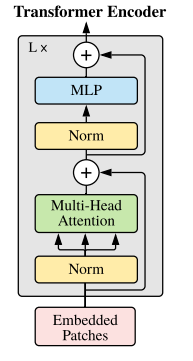

And we will go into the details of each of the sublayers using the architecture presented in the paper [Vision Transformers for Remote Sensing Image Classification](https://www.mdpi.com/2072-4292/13/3/516).

Layer Normalization normalizes the activations of a layer for each input independently, making the mean and variance of the layer outputs consistent. It first computes the mean and variance
$$
\mu = \frac{1}{H} \sum_{i=1}^{H} x_i, \quad \sigma^2 = \frac{1}{H} \sum_{i=1}^{H} (x_i - \mu)^2,
$$
then each element of the representation is normalized
$$
\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}
,$$ with $\epsilon$ a small constant to avoid division by zero. And finally it scales and shifts the normalized values using learnable parameters $$y_i = \gamma \hat{x}_i + \beta.$$

In the multihead attention we will use multi-head self attention, which basically means that for the query, key and value vector we will use the same input vector.

The process begins by projecting the input vector $w$ using linear transformations: $$q = W^Qw + b_q, \quad k = W^K w + b_k, \quad v = W^V w + b_v.$$ Next, the scaled dot-product attention is computed. For each $q$, representing a patch, the dot product is calculated with all the $k$ vectors:
$$\text{Attention}(q, K, V) = \text{softmax}\left(\frac{q K^T}{\sqrt{D_k}}\right) V$$
Here $D_k$ is the scaling factor,given by the dimension of each sub-representation divided by the number of heads $H$.
This process is repeated $H$ times, operating on $H$ sub-representations of the input vector, allowing the attention mechanism to focus on different aspects of the data simultaneously.

Finally, it concatenates the results into a single tensor, this tensor has the same dimensions as the initial tensor.
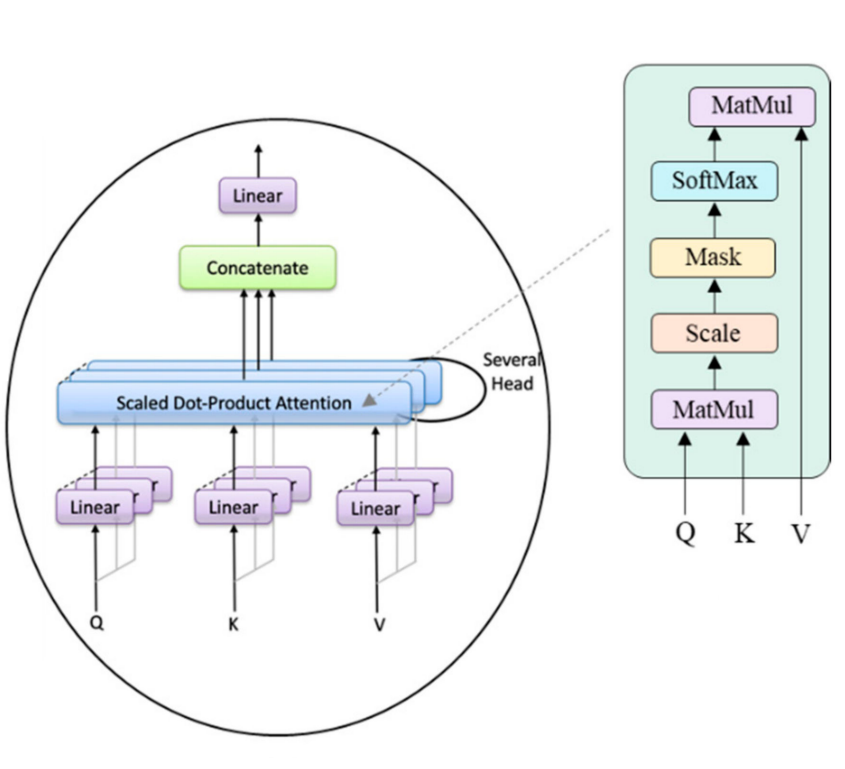

The good part is that this is already implemented in pytorch, so we can simply use torch.nn.MultiheadAttention with the dimension of the inputs and the number of heads and pass it the same input tensoir three times for the self attention mechanism.

In [10]:
class Transformer(torch.nn.Module):
  """
  A multi-layer transformer model that applies multi-head self-attention (MSA) and
  a feedforward MLP for each layer.

  Args:
  - dimension (int): The dimensionality of the input and output embeddings.
  - layers_dict (list): A list of dictionaries, each containing:
      - "heads" (int): Number of attention heads.
      - "mlp_ratio" (int): Ratio to scale the hidden dimension of the MLP relative to the `dimension`.

  Methods:
  - forward(tokens): Applies the transformer layers on the input `tokens` and returns the final output tokens.

  Attributes:
  - msa_layers: A list of multi-head attention layers.
  - ln_layers_a: A list of layer normalization layers before the attention.
  - ln_layers_b: A list of layer normalization layers before the MLP.
  - mlp_layers: A list of MLP layers applied after attention.
  """
  def __init__(self,dimension:int, layers_dict:list):
    super().__init__()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.to(device)
    self._layers = layers_dict
    self.msa_layers = torch.nn.ModuleList().to(device)
    self.ln_layers_a = torch.nn.ModuleList().to(device)
    self.ln_layers_b = torch.nn.ModuleList().to(device)
    self.mlp_layers = torch.nn.ModuleList().to(device)
    for layer in self._layers:
      if any(key not in layer.keys() for key in ["heads","mlp_ratio"]):
        raise ValueError("Layers must have heads and mlp_ratio keys")
      self.msa_layers.append(torch.nn.MultiheadAttention(dimension,layer["heads"]).to(device))
      self.ln_layers_a.append(torch.nn.LayerNorm(dimension).to(device))
      self.ln_layers_b.append(torch.nn.LayerNorm(dimension).to(device))
      self.mlp_layers.append(torch.nn.Sequential(torch.nn.Linear(dimension,dimension*layer["mlp_ratio"]).to(device),
                                                 torch.nn.GELU().to(device),
                                                 torch.nn.Linear(dimension*layer["mlp_ratio"],dimension).to(device)))

  def forward(self,tokens:torch.Tensor):
    for i in range(len(self._layers)):
      ln_out_a = self.ln_layers_a[i](tokens)
      msa_out , _ = self.msa_layers[i](ln_out_a,ln_out_a,ln_out_a)
      tokens = tokens + msa_out
      ln_out_b = self.ln_layers_a[i](tokens)
      mlp_out = self.mlp_layers[i](ln_out_b)
      tokens = tokens + mlp_out
    return tokens



For the residual convolutional layers, the architecture goes as follows without the batchnorm layer 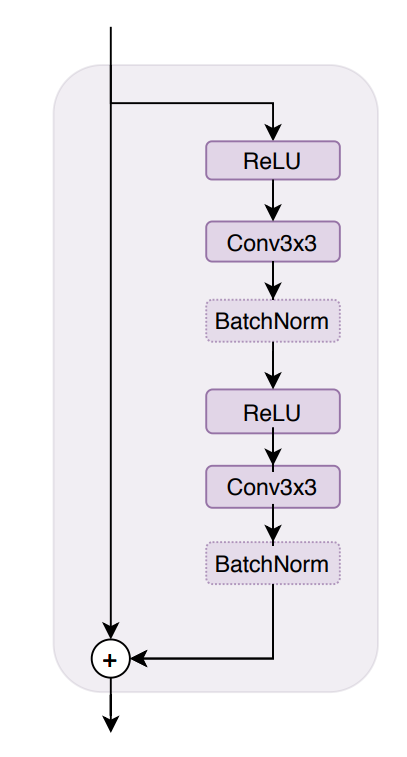

In [11]:
class ResidualConvBlock(torch.nn.Module):
  """
  A residual convolution block that applies two convolutional layers with ReLU activations,
  and adds the input tensor to the output (residual connection).

  Args:
  - in_channels (int): Number of input channels.
  - out_channels (int): Number of output channels.
  - stride (int): Stride for the convolution operations.
  - padding (int): Padding for the convolution operations.

  Methods:
  - forward(tokens): Applies the residual convolution block to the input tensor and returns
    the sum of the input and the output (residual connection).

  Attributes:
  - relu1: ReLU activation after the first convolution.
  - conv1: First convolutional layer.
  - relu2: ReLU activation after the second convolution.
  - conv2: Second convolutional layer.
  """
  def __init__(self, in_channels: int, out_channels: int, stride:int, padding:int):
    super().__init__()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.to(device)
    self.relu1 = torch.nn.ReLU().to(device)
    self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=padding).to(device)
    self.relu2 = torch.nn.ReLU().to(device)
    self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=padding).to(device)

    torch.nn.init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')
    torch.nn.init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')

  def forward(self, tokens:torch.Tensor):
    single_image = False
    if tokens.dim() == 3:
      single_image = True
      tokens = tokens.unsqueeze(0)

    x = self.relu1(tokens.permute(0,3,1,2))
    x = self.conv1(x)
    x = self.relu2(x)
    x = self.conv2(x)
    if single_image:
      return tokens.squeeze(0) + x.squeeze(0).permute(1,2,0)
    else:
      return x.permute(0,2,3,1) + tokens

Finally, the fusion layers can be built from the previosluy defined architectures as 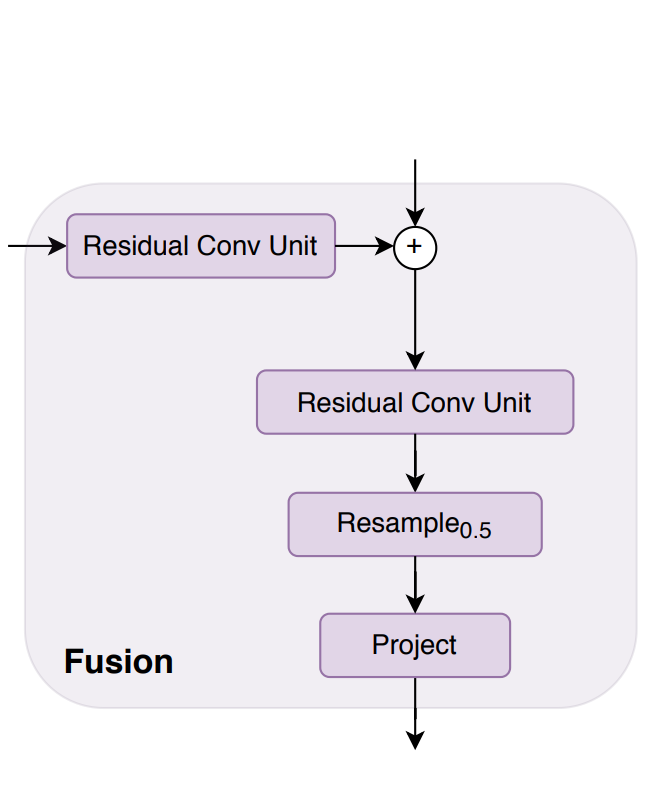

In [12]:
class fusion(torch.nn.Module):
  """
  A module for fusion of features using residual convolutions and resampling.

  Args:
  - in_channels (int): Number of input channels to the first residual convolution.
  - out_channels (int): Number of output channels after the convolutions.
  - stride (int): Stride for the convolution operations.
  - padding (int): Padding for the convolution operations.
  - size_ratio (float): Ratio to scale the input for resampling.
  - patch_size (int): Patch size used on the encoding.

  Methods:
  - forward(reassemble_tokens, fusion_tokens=None): Takes two tensors, processes the primary one
    through convolutions, applies optional fusion with another tensor, and returns the processed output
    after resampling and projection.

  Attributes:
  - res_conv_a: A residual convolution block for processing the input tokens.
  - res_conv_b: A second residual convolution block for further processing.
  - resample: A reassemble module for resampling the features.
  - projection: A 1x1 convolution for projecting the features to the output channels.
  """
  def __init__(self, in_channels: int, out_channels: int, stride:int, padding:int,size_ratio:float, patch_size:int):
    super().__init__()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.to(device)
    self.res_conv_a = ResidualConvBlock(in_channels,out_channels,stride,padding).to(device)
    self.res_conv_b = ResidualConvBlock(out_channels,out_channels,stride,padding).to(device)
    self.resample = reassemble(size_ratio,out_channels,out_channels,patch_size).resample_layer.to(device)
    self.projection = torch.nn.Conv2d(in_channels = out_channels, out_channels=out_channels,kernel_size=(1,1)).to(device)

  def forward(self,reassemble_tokens:torch.Tensor,fusion_tokens:torch.Tensor=None):
    x  = self.res_conv_a(reassemble_tokens)

    if fusion_tokens is not None:
      x = x + fusion_tokens
    x = self.res_conv_b(x)

    single_image = False
    if x.dim() == 3:
      single_image = True
      x = x.unsqueeze(0)

    x = self.resample(x.permute(0,3,1,2))
    x = self.projection(x)
    if single_image:
      return x.squeeze(0).permute(1,2,0)
    else:
      return x.permute(0,2,3,1)


The head layer for the monocular depth estimation can also be easily built using conv layers and resample layer as

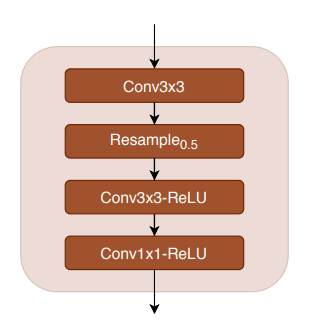

In this case, we will retuirnjust one channel to match the form of the depth maps from the dataset.

In [13]:
class Head(torch.nn.Module):
  """
  A convolutional head used for final processing features in the network.

  Args:
  - in_channels (int): Number of input channels to the first convolution.
  - out_channels (int): Number of output channels after the convolutions.
  - stride (int): Stride of the convolutions.
  - padding (int): Padding for the convolutions.

  Methods:
  - forward(tokens): Takes a tensor of tokens as input, processes them through convolutions,
    resampling, and generates the final output.

  Attributes:
  - conv: A 2D convolution layer.
  - resample: A reassemble module for resampling the features.
  - conv_relu: A sequence of convolution followed by ReLU activation.
  - conv_rule_final: The final convolution layer to output a single-channel feature map.
  """
  def __init__(self, in_channels: int, out_channels: int, stride:int, padding:int):
    super().__init__()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.to(device)
    self.conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1).to(device)
    self.resample =  reassemble(0.5,out_channels,out_channels,1).resample_layer.to(device)
    self.conv_relu = torch.nn.Sequential(torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1).to(device),
                                         torch.nn.ReLU().to(device))
    self.conv_rule_final = torch.nn.Sequential(torch.nn.Conv2d(out_channels, 1, kernel_size=3, stride=1, padding=1).to(device),
                                               torch.nn.ReLU().to(device))

    torch.nn.init.kaiming_normal_(self.conv_relu[0].weight, nonlinearity='relu')
    torch.nn.init.kaiming_normal_(self.conv_rule_final[0].weight, nonlinearity='relu')

  def forward(self,tokens:torch.Tensor):

    single_image = False
    if tokens.dim() == 3:
      single_image = True
      tokens = tokens.unsqueeze(0)

    x = self.conv(tokens.permute(0,3,1,2))

    x = self.resample(x)

    x = self.conv_relu(x)

    x = self.conv_rule_final(x).squeeze(0)
    if single_image:
      return x.squeeze(0)
    else:
      return x

Finally, we mix all previously defiend block together. Due to computatinal limitation, we will not be able to train the whole net but a small version that follows the idea previosly discussed.

In [14]:
class DPT(torch.nn.Module):
  def __init__(self, attention_heads:int):
    """
    A lighter version of a transformer-based model with reduced complexity.

    This model includes:
    - Encoder: A feature extractor for the input image.
    - Transformer: A transformer with a specified number of attention heads, applied to the encoded features.
    - Reassemble: A module for reassembling the features after transformer processing.
    - Fusion: A module for fusing the features from the reassembled tokens.
    - Head: The final layer that generates the model's output.

    This model omits several transformer and reassemble layers due to limitations.

    Args:
    - attention_heads (int): Number of attention heads for the transformer.

    Methods:
    - forward(img): Passes an input image through the encoder, transformer, reassemble, fusion, and head to get the output.
    """
    super().__init__()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.to(device)
    self.encoder = encoder(16,768,(3, 576, 768))
    self.encoder.to(device)
    self.transformer_a = Transformer(768,[{"heads":attention_heads,"mlp_ratio":4}]*3)
    self.transformer_a.to(device)
    # self.transformer_b = Transformer(768,[{"heads":attention_heads,"mlp_ratio":4}]*6)
    # self.transformer_b.to(device)
    # self.transformer_c = Transformer(768,[{"heads":attention_heads,"mlp_ratio":4}]*9)
    # self.transformer_c.to(device)
    # self.transformer_d = Transformer(768,[{"heads":attention_heads,"mlp_ratio":4}]*12)
    # self.transformer_d.to(device)

    self.reassemble_a = reassemble(4,768,256,16)
    self.reassemble_a.to(device)
    # self.reassemble_b = reassemble(8,768,256,16)
    # self.reassemble_b.to(device)
    # self.reassemble_c = reassemble(16,768,256,16)
    # self.reassemble_c.to(device)
    # self.reassemble_d = reassemble(32,768,256,16)
    # self.reassemble_d.to(device)

    self.fusion_a = fusion(256,256,1,1,0.5,1)
    self.fusion_a.to(device)
    # self.fusion_b = fusion(256,256,1,1,0.5,1)
    # self.fusion_b.to(device)
    # self.fusion_c = fusion(256,256,1,1,0.5,1)
    # self.fusion_c.to(device)
    # self.fusion_d = fusion(256,256,1,1,0.5,1)
    # self.fusion_d.to(device)

    self.head = Head(256,256,1,1)
    self.head.to(device)
  def forward(self,img:torch.Tensor):
    _,_, H, W = img.shape
    tokens = self.encoder(img)
    tokens_a = self.transformer_a(tokens)
    # tokens_b = self.transformer_b(tokens_a)
    # tokens_c = self.transformer_c(tokens_b)
    # tokens_d = self.transformer_d(tokens_c)

    tokens_reassembled_a = self.reassemble_a(tokens_a,(H,W))
    # tokens_reassembled_b = self.reassemble_b(tokens_b,(H,W))
    # tokens_reassembled_c = self.reassemble_c(tokens_c,(H,W))
    # tokens_reassembled_d = self.reassemble_d(tokens_d,(H,W))

    # tokens_fusion_d = self.fusion_d(tokens_reassembled_d)
    # tokens_fusion_c = self.fusion_c(tokens_reassembled_c,tokens_fusion_d)
    # tokens_fusion_b = self.fusion_b(tokens_reassembled_b,tokens_fusion_c)
    tokens_fusion_a = self.fusion_a(tokens_reassembled_a)#,tokens_fusion_b)

    return self.head(tokens_fusion_a)

#Loss function

For the loss function, we will follow the implementation found in the paper [Towards Robust Monocular Depth Estimation:
Mixing Datasets for
Zero-shot Cross-dataset Transfer](https://arxiv.org/pdf/1907.01341).

## sstrim loss

The idea of this loss is to construct a loss robus to outliers. Given a disparity map $\mathbf{d}$, we compute the shift $t$ and scale $s$ of the map
$$t(\mathbf{d}) = \text{median}(\mathbf{d}), \quad s(\mathbf{d}) = \frac{1}{M}\sum_{i=1}^M \left| \mathbf{d} - t(\mathbf{d}) \right|, $$ where $M$ is the total number of pixels. Then the disparity maps is transformed as
$$\hat{\mathbf{d}} = \frac{\mathbf{d} - t(\mathbf{d})}{s(\mathbf{d})}.$$
Defining $\mathbf{d}$ as the prediction disparity and $\mathbf{d^*}$ the ground truth, the sstrim loss is given by
$$\mathcal{L}_{\text{sstrim}}(\mathbf{d},\mathbf{d^*}) = \frac{1}{2M}\sum_{j=1}^{U_M} \left|\hat{\mathbf{d}}_j - \hat{\mathbf{d^*}}_j \right|,$$
with $U_M = 0.8M$ set by experimental results and we have arranged the transformed disparity maps to follow $\left|\hat{\mathbf{d}}_j - \hat{\mathbf{d^*}}_j \right| \leq \left|\hat{\mathbf{d}}_{j+1} - \hat{\mathbf{d^*}}_{j+1} \right|$.

##Reg loss

For the reg loss, we follow the same transformation for the disparity maps, and then, we construct the reg loss as
$$\mathcal{L}_{\text{reg}}(\mathbf{d},\mathbf{d^*}) = \frac{1}{M} \sum_{k=1}^{K}\sum_{i=1}^M \left( \left|\nabla_x R_i^k\right| + \left|\nabla_y R_i^k\right|\right),$$
with $R_{i} = \hat{\mathbf{d}}_i - \hat{\mathbf{d^*}_i}$ and $R^k$ denotes the same difference of disparity maps but at scale $k$, and $\nabla_{x|y}$ is the gradient w.r.t the $x|y$ axis. For the scale downsampling we will use interpolation from torch functionalities.

## Final loss

The finall loss is then a sum opf these two previosly defined losses
$$\mathcal{L} = \frac{1}{N}\sum_{n=1}^N\left[\mathcal{L}_{\text{sstrim}}(\mathbf{d}^n,(\mathbf{d^*})^n) + \alpha \mathcal{L}_{\text{reg}}(\mathbf{d}^n,(\mathbf{d^*})^n)\right],$$ with $N$ the length of the training dataset and $\alpha=0.5$.

In [15]:
class robust_loss(torch.nn.Module):
  """
    A custom loss function that combines regularization and robust loss calculation for disparity prediction.

    Methods:
    - flatten(img, dim=-2): Flattens the input tensor along the specified dimension.
    - median(img, dim=-1): Computes the median along the specified dimension.
    - scale(img, dim=-1): Scales the tensor based on median and absolute deviation.
    - transform(img): Normalizes the input tensor by transforming it using median and scale.
    - downsample_disparity(disparity_map, scales=4): Downsamples the disparity map using bilinear interpolation.
    - loss_reg(pred, Y): Computes the regularization loss between the predicted and target disparity maps.
    - loss_sstrim(pred, Y): Computes a trimmed loss by considering the top 80% of the absolute differences.
    - forward(pred, Y): Computes the final loss by combining the regularization and trimmed losses.
    """
  def __init__(self) -> None:
    super().__init__()

  def flatten(self,img:torch.Tensor,dim:int=-2):
    return img.flatten(start_dim=dim)
  def median(self,img:torch.Tensor, dim:int=-1):
    return img.median(dim=dim).values.unsqueeze(-1)
  def scale(self,img:torch.Tensor,dim:int=-1):
    median = self.median(img,dim=dim)
    return ((1/img.shape[-1])*(img-median).abs().sum(dim=dim)).unsqueeze(-1)
  def transform(self,img:torch.Tensor):
    flattened = self.flatten(img)
    median = self.median(flattened)
    scale = self.scale(flattened)
    return (flattened - median)/(scale + 1e-5)
  def downsample_disparity(self, disparity_map, scales=4):
    downsampled_maps = [disparity_map]
    for _ in range(1, scales):
        # Downsample by a factor of 2 using bilinear interpolation
        disparity_map = torch.nn.functional.interpolate(disparity_map, scale_factor=0.5, mode='bilinear')
        downsampled_maps.append(disparity_map)
    return downsampled_maps

  def loss_reg(self,pred,Y):
    batch_size, C,H, W = pred.shape
    transformed_pred = self.transform(pred)
    transformed_Y = self.transform(Y)
    diff = transformed_pred - transformed_Y
    unflatten_diff = torch.unflatten(diff,dim=-1,sizes = (int(H),int(W)))
    downsample_disparities = self.downsample_disparity(unflatten_diff)
    sum=torch.zeros((batch_size,1),device=pred.device)
    for downsampled in downsample_disparities:
      x_gradient = torch.gradient(downsampled,dim=-2)[0]
      y_gradient = torch.gradient(downsampled,dim=-1)[0]
      gradient_sum = abs(x_gradient) + abs(y_gradient)
      flattened_gradient_sum = self.flatten(gradient_sum)
      sum += flattened_gradient_sum.sum(dim=-1)
    return sum*(1/(2*H*W))

  def loss_sstrim(self,pred,Y):
    transformed_pred = self.transform(pred)
    transformed_Y = self.transform(Y)
    abs_diff = abs(transformed_pred - transformed_Y)
    sorted_abs_diff = abs_diff.sort(dim=-1).values
    U_m = int(0.8*sorted_abs_diff.shape[-1])
    sliced_sorted_abs_diff = sorted_abs_diff[:,:,:U_m]
    return sliced_sorted_abs_diff.sum(dim=-1)*(1/(2*sorted_abs_diff.shape[-1]))

  def forward(self,pred,Y):
    return (0.5*self.loss_reg(pred,Y) + self.loss_sstrim(pred,Y)).mean(dim=0)


In [16]:

loss = robust_loss()
dpt_model = DPT(12)

In [17]:
from tqdm import tqdm
# loaded_training = [train_dataset[i] for i in tqdm(range(len(train_dataset)), desc="Loading Training Data")]
loaded_testing = [test_dataset[i] for i in tqdm(range(len(test_dataset)), desc="Loading Testing Data")]

Loading Testing Data: 100%|██████████| 1410/1410 [00:26<00:00, 52.24it/s]


In [18]:
# train_data = [item[0] for item in loaded_training]
# train_labels = [item[1] for item in loaded_training]
test_data = [item[0] for item in loaded_testing]
test_labels = [item[1] for item in loaded_testing]
test_cam = [item[2] for item in loaded_testing]
# torch.save({'train_data': train_data, 'train_labels': train_labels}, '/content/drive/My Drive/train_data.pth')
# torch.save({'test_data': test_data, 'test_labels': test_labels}, '/content/drive/My Drive/test_data.pth')

In [19]:
# from google.colab import files
# torch.save({'train_data': train_data, 'train_labels': train_labels}, 'train_data.pth')
# torch.save({'test_data': test_data, 'test_labels': test_labels}, 'test_data.pth')
# files.download('train_data.pth')
# files.download('test_data.pth')

In [19]:
class InMemoryDataset(Dataset):
  """
  A dataset class that stores data and labels in memory.

  Parameters:
  - data: Input data (torch.Tensor or numpy.ndarray).
  - labels: Corresponding labels (torch.Tensor or numpy.ndarray).

  Methods:
  - __len__(): Returns the number of samples.
  - __getitem__(idx): Returns the data and label at index `idx`.
  """
  def __init__(self, data, labels):
      self.data = data
      self.labels = labels

  def __len__(self):
      return len(self.data)

  def __getitem__(self, idx):
      return self.data[idx], self.labels[idx]

In [20]:
# train_dataset = InMemoryDataset(train_data, train_labels)
test_dataset = InMemoryDataset(test_data, test_labels)

In [21]:
# train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=12, shuffle=False)

Epoch [10], Loss training: 0.27435


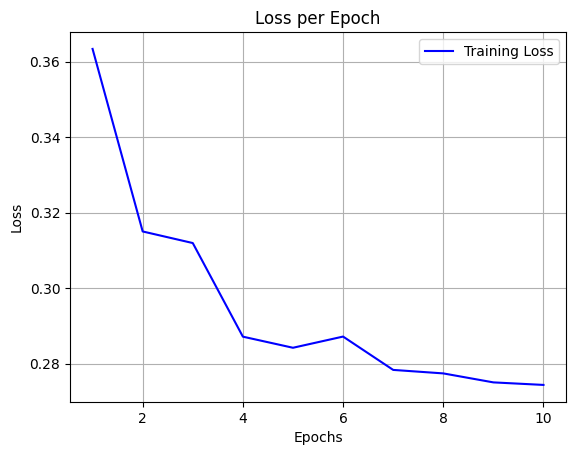

In [30]:
loss_values_training = []
optimizer = torch.optim.Adam(lr=0.0001,params=dpt_model.parameters())
for num_epochs in range(10):
  running_loss = 0
  for obs in train_loader:
    clear_cache()
    # check_gpu_memory()
    x,y = obs[0],obs[1]
    X,Y = x.to(torch.device("cuda")),y.to(torch.device("cuda"))

    out = dpt_model(X)
    if out.dim() == 3:
      out = out.unsqueeze(0)
    loss_value = loss(out,Y)
    optimizer.zero_grad()
    loss_value.backward()
    optimizer.step()
    running_loss += loss_value.item()
    if np.isnan(loss_value.item()):
      print("Loss is nan")
      break
  if np.isnan(running_loss):
    print("Loss is nan")
    break
  loss_values_training.append(running_loss/len(train_loader))
  clear_output(wait=True)
  print(f"Epoch [{len(loss_values_training)}], Loss training: {loss_values_training[-1]:.5f}")
  plt.plot(range(1, len(loss_values_training) + 1), loss_values_training,label='Training Loss', color='blue')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Loss per Epoch')
  plt.legend()
  plt.grid(True)
  plt.show()


In [31]:
# torch.save(dpt_model.state_dict(),'/content/drive/My Drive/weights.pth')

In [32]:
# torch.save(dpt_model, '/content/drive/My Drive/3d_recons_model.pth')

In [22]:
dpt_model = torch.load('/content/drive/My Drive/3d_recons_model.pth')

<ipython-input-22-87abcee21303>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dpt_model = torch.load('/content/drive/My Drive/3d_recons_model.pth')


At this point, I cannot keep training the model due to resources, so naturaly this model will perform badly.

In [25]:
check_gpu_memory()

Free memory: 41.89 GB
Total memory: 42.48 GB


In [24]:
clear_cache()

In order to test, we will compute similar metrics to the DPT model paper, namely, the threshold accuracy $\delta$, Absolute Relative Error, Root Mean Square Error and Log 10 error.

The threshold accuracy measures the percentage of pixels where the predicted disparity map is within a certain relative threshold of the ground truth depth
$$\delta = \frac{1}{M} \sum_{i=1}^M 1\left( \max\left[\frac{\mathbf{d}_i}{\mathbf{d^*}_i}, \frac{\mathbf{d^*}_i}{\mathbf{d}_i} < \delta \right]\right) $$
where $1(\cdot)$ is the indicator function, equal to 1 if the condition is true, otherwise 0. In the paper, the analyse the cases $\delta = [1.25,1.25^2,1.25^3]$.

In [80]:

def delta_metrics(pred: torch.Tensor, gt: torch.Tensor, thresholds=(1.25, 1.25**2, 1.25**3)):
    """
    Compute δ metrics (Threshold Accuracy) for depth predictions.

    Args:
        pred (torch.Tensor): Predicted depth map (batch_size x H x W or N x H x W).
        gt (torch.Tensor): Ground truth depth map (same size as pred).
        thresholds (tuple): Threshold values (e.g., (1.25, 1.25**2, 1.25**3)).

    Returns:
        dict: A dictionary with δ_k metrics for each threshold.
    """

    assert pred.shape == gt.shape, "Prediction and ground truth must have the same shape"

    epsilon = 1e-6
    pred = pred.clamp(min=epsilon)
    gt = gt.clamp(min=epsilon)

    ratio = torch.max(pred / gt, gt / pred)

    results = {}

    for threshold in thresholds:
        results[f'delta_{threshold:.2f}'] = (ratio < threshold).float().mean().item()

    return results

The Absolute Relative Error quantifies the average relative error between the predicted disparity map and the ground truth depth
$$\text{AbsRel} = \frac{1}{M}\sum_{i=1}^M \frac{\left|\mathbf{d^*}_i - \mathbf{d}_i  \right|}{\mathbf{d}_i}$$

In [81]:
def abs_rel_error(pred: torch.Tensor, gt: torch.Tensor):
    """
    Compute the Absolute Relative Error (AbsRel) for depth predictions.

    Args:
        pred (torch.Tensor): Predicted depth map (batch_size x H x W or N x H x W).
        gt (torch.Tensor): Ground truth depth map (same size as pred).

    Returns:
        float: The absolute relative error.
    """

    assert pred.shape == gt.shape, "Prediction and ground truth must have the same shape"

    epsilon = 1e-6
    gt = gt.clamp(min=epsilon)

    abs_rel = torch.abs(pred - gt) / gt
    return abs_rel.mean().item()

The RMSE is the standard measurement
$$\text{RMSE} = \sqrt{\frac{1}{M}\sum_{i=1}^M(\mathbf{d^*}_i - \mathbf{d}_i)}$$

In [82]:
def rmse_error(pred: torch.Tensor, gt: torch.Tensor):
    """
    Compute the Root Mean Squared Error (RMSE) for depth predictions.

    Args:
        pred (torch.Tensor): Predicted depth map (batch_size x H x W or N x H x W).
        gt (torch.Tensor): Ground truth depth map (same size as pred).

    Returns:
        float: The RMSE.
    """

    assert pred.shape == gt.shape, "Prediction and ground truth must have the same shape"

    mse = torch.mean((pred - gt) ** 2)
    rmse = torch.sqrt(mse)
    return rmse.item()

And the $\log_{10}$ error is
$$\log_{10} = \frac{1}{M}\sum_{i=1}^M \left[\log_{10}(\mathbf{d^*}_i) - \log_{10}(\mathbf{d}_i) \right]$$

In [83]:
def log10_error(pred: torch.Tensor, gt: torch.Tensor):
    """
    Compute the Log10 Error for depth predictions.

    Args:
        pred (torch.Tensor): Predicted depth map (batch_size x H x W or N x H x W).
        gt (torch.Tensor): Ground truth depth map (same size as pred).

    Returns:
        float: The Log10 Error.
    """
    assert pred.shape == gt.shape, "Prediction and ground truth must have the same shape"

    epsilon = 1e-6
    pred = pred.clamp(min=epsilon)
    gt = gt.clamp(min=epsilon)

    log_diff = torch.abs(torch.log10(pred) - torch.log10(gt))
    return log_diff.mean().item()

In [26]:
dpt_model.eval()

DPT(
  (encoder): encoder(
    (linear): Linear(in_features=768, out_features=768, bias=True)
  )
  (transformer_a): Transformer(
    (msa_layers): ModuleList(
      (0-2): 3 x MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
    )
    (ln_layers_a): ModuleList(
      (0-2): 3 x LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (ln_layers_b): ModuleList(
      (0-2): 3 x LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (mlp_layers): ModuleList(
      (0-2): 3 x Sequential(
        (0): Linear(in_features=768, out_features=3072, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=3072, out_features=768, bias=True)
      )
    )
  )
  (reassemble_a): reassemble(
    (linear_read): Linear(in_features=1536, out_features=768, bias=True)
    (gelu_read): GELU(approximate='none')
    (projection_layer): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1))
    (

In [104]:
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)
deltas = []
abs_rels = []
rmses = []
log10s = []
for obs in test_loader:
  with torch.no_grad():
    clear_cache()
    out = dpt_model(obs[0].to(torch.device("cuda")))
    deltas.append(delta_metrics(out,obs[1].to(torch.device("cuda"))))
    abs_rels.append(abs_rel_error(out,obs[1].to(torch.device("cuda"))))
    rmses.append(rmse_error(out,obs[1].to(torch.device("cuda"))))
    log10s.append(log10_error(out,obs[1].to(torch.device("cuda"))))

In [114]:
#since the previos metrics were averaged on batch size, we return the total sums to avearge on the entire test set
factors= [4]*(len(deltas)-1) + [2]
for i in range(len(deltas)-1):
  for key, value in deltas[i].items():
    deltas[i][key] *= factors[i]
  abs_rels[i] *= factors[i]
  rmses[i] *= factors[i]
  log10s[i] *= factors[i]

In [122]:
stats = {"delta_1.25":0,"delta_1.56":0,"delta_1.95":0,"abs_rel":0,"rmse":0,"log10":0}
for i in range(len(deltas)-1):
  for key, value in stats.items():
    try:
      stats[key] += deltas[i][key]
    except KeyError:
      pass
  stats["abs_rel"] += abs_rels[i]
  stats["rmse"] += rmses[i]
  stats["log10"] += log10s[i]

for key, value in stats.items():
  stats[key] /= len(deltas)

We then obtain the following metrics for our particular model

In [124]:
stats

{'delta_1.25': 0.8584792104717238,
 'delta_1.56': 0.8593411052661549,
 'delta_1.95': 0.8602796478101999,
 'abs_rel': 129230100643.51851,
 'rmse': 3472579.346140227,
 'log10': 21.57397571974368}

This is as expected: we obtain significantly worse statistics compared to the values reported in the DPT paper. This is reasonable, as we are training only this part of the model
 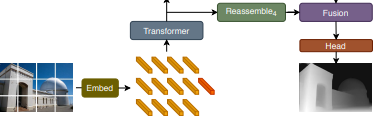

which is considerably less powerful than the original one. Additionally, we are working on a subsample of the Blended dataset due to storage limitations on the drive, whereas the paper uses more than a million images. Moreover, we trained for only 10 epochs, compared to the 60 epochs reported in the paper, again due to GPU limitations. Therefore, it is normal for our model to perform poorly under these conditions.

We can also conduct a visual inspection of what the model has learned so far.

In [142]:
test_out = dpt_model(obs[0].to("cuda"))

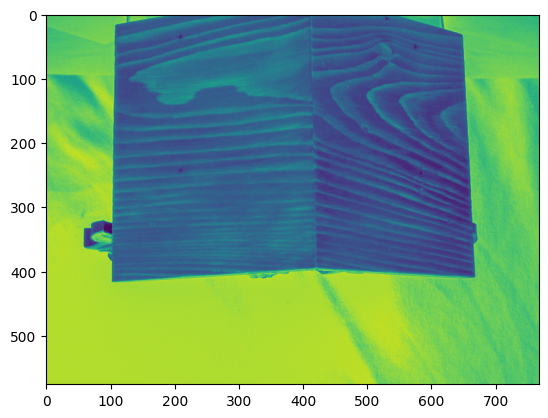

In [158]:
#This is what the model should have learned
plt.imshow(obs[0].detach().cpu().numpy()[0,0])

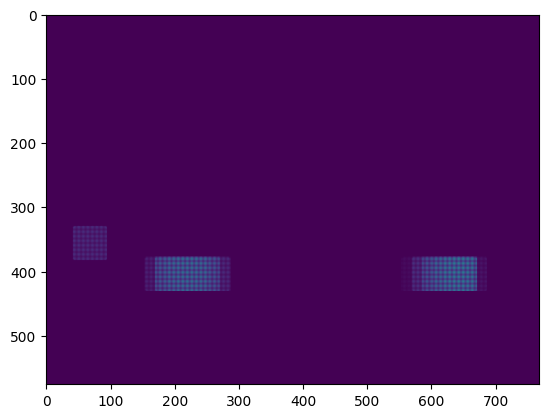

In [159]:
#This is what it has learned so far
plt.imshow(test_out.detach().cpu().numpy()[0,0])

The model did not have the chance to learn a lot from the training phase, it attempted to learn some depths on different parts of the input images but convergence was not good.

Finally, we can use the depth model to create a 3D reconstruction method by implementing the equation
$$\textbf{X}_{\text{world}} = Z(u,v) \left[R | T\right]^{-1} K^{-1}\textbf{x} $$, with $Z \propto 1/D $ with $D$ the prediction of the model.

In [77]:
obs_test = test_dataset[0][0].unsqueeze(0).to("cuda")
cam_extrinsics = test_cam[0]["extrinsic"]
cam_intrinsics = test_cam[0]["intrinsic"]
focal_length = cam_intrinsics[0][0]

In [111]:
def reconstruct_3d(input_image,model, intrinsic_matrix, extrinsic_matrix,device='cuda'):
    """
    Reconstructs 3D world coordinates for each pixel in the input image based on the model's disparity map
    and the provided camera intrinsic and extrinsic matrices.

    Parameters:
    - input_image (torch.Tensor): Input image tensor (H, W, C).
    - model (torch.nn.Module): Model that predicts the disparity map.
    - intrinsic_matrix (numpy.ndarray or torch.Tensor): 3x3 camera intrinsic matrix.
    - extrinsic_matrix (numpy.ndarray or torch.Tensor): 4x4 camera extrinsic matrix.
    - device (str, optional): Device ('cuda' or 'cpu'). Default is 'cuda'.

    Returns:
    - torch.Tensor: 3D world coordinates (H, W, 3).
    """
    model.eval()


    intrinsic_matrix = torch.tensor(intrinsic_matrix, dtype=torch.float32)
    extrinsic_matrix = torch.tensor(extrinsic_matrix, dtype=torch.float32)

    if input_image.dim() == 3:
        input_image = input_image.unsqueeze(0)

    with torch.no_grad():
        disparity_map = model(input_image).squeeze(0)


    disparity_map = disparity_map.float()


    H, W = disparity_map.shape

    u, v = torch.meshgrid(torch.arange(0, W), torch.arange(0, H))
    u, v = u.flatten(), v.flatten()

    pixel_coords = torch.stack([u, v, torch.ones_like(u)], dim=-1).float().to(device)

    depth = intrinsic_matrix[0][0]/ (disparity_map.flatten() + 1e-5)

    pixel_coords = pixel_coords * depth.unsqueeze(-1).to(device)

    K_inv = torch.linalg.inv(intrinsic_matrix).to(device)
    pixel_coords = pixel_coords @ K_inv.T

    RT_inv = torch.linalg.inv(extrinsic_matrix).to(device)
    pixel_coords = pixel_coords @ RT_inv[:3, :3].T + RT_inv[:3, 3]


    world_coords = pixel_coords.view(H, W, 3)

    return world_coords

In [112]:
test_3d_rec = reconstruct_3d(obs_test, dpt_model, cam_intrinsics, cam_extrinsics)

In [113]:
#print to verify dimensions
print(test_3d_rec.shape)

torch.Size([576, 768, 3])
